# CGroup and CPUset

This notebook demonstrates the workload behaviour for cgroup and cpuset in EAS workshop

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '192.168.1.101',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "eas_cgroup_cpuset",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

05:08:59  INFO    :         Target - Using base path: /data/lisa_fork/lisa
05:08:59  INFO    :         Target - Loading custom (inline) target configuration
05:08:59  INFO    :         Target - Loading custom (inline) test configuration
05:08:59  INFO    :         Target - External tools using:
05:08:59  INFO    :         Target -    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
05:08:59  INFO    :         Target -    CATAPULT_HOME: /data/lisa_fork/lisa/tools/catapult
05:08:59  INFO    :         Target - Devlib modules to load: ['bl', 'hwmon', 'cpufreq']
05:08:59  INFO    :         Target - Connecting Android target [192.168.1.101:5555]
05:08:59  INFO    :         Target - Connection settings:
05:08:59  INFO    :         Target -    {'device': '192.168.1.101:5555'}
05:09:02  INFO    :         Target - Initializing target workdir:
05:09:02  INFO    :         Target -    /data/local/tmp/devlib-target
05:09:08  INFO    :         Target - Topology:
05:09:08  INFO    :         Target -

# Workload configuration

In [5]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',    
    
    # 2. define the "profile" of each task
    params={
        'task_p1': Periodic(
            period_ms=100,          # period
            duty_cycle_pct=10,      # duty cycle
            duration_s=10,           # duration    
            cpus="0",
        ).get(),
        'task_p2': Periodic(
            period_ms=100,          # period
            duty_cycle_pct=10,      # duty cycle
            duration_s=10,          # duration    
            cpus=str(target.bl.bigs[0]),    # "1"
        ).get(),
        'task_r1': Ramp(
            start_pct=10,           # intial load
            end_pct=30,             # end load
            delta_pct=5,            # load % increase...
            time_s=1,               # ... every 1[s]
            cpus="2",
        ).get(),
        'task_r2': Ramp(
            start_pct=10,           # intial load
            end_pct=30,             # end load
            delta_pct=5,            # load % increase...
            time_s=1,               # ... every 1[s]
            cpus="3"
        ).get(),
    },    
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

05:09:47  INFO    :          WlGen - Setup new workload simple
05:09:47  DEBUG   :          WlGen - Setup step [postrun] callback to [__postrun] function
05:09:47  DEBUG   :          WlGen - Configuring a profile-based workload...
05:09:47  DEBUG   :          RTApp - ref on big cpu: 1
05:09:47  INFO    :          RTApp - Workload duration defined by longest task
05:09:47  INFO    :          RTApp - Default policy: SCHED_OTHER
05:09:47  INFO    :          RTApp - ------------------------
05:09:47  INFO    :          RTApp - task [task_p1], sched: using default policy
05:09:47  INFO    :          RTApp -  | calibration CPU: 1
05:09:47  INFO    :          RTApp -  | loops count: 1
05:09:47  INFO    :          RTApp -  | CPUs affinity: 0
05:09:47  INFO    :          RTApp - + phase_000001: duration 10.000000 [s] (100 loops)
05:09:47  INFO    :          RTApp - |  period   100000 [us], duty_cycle  10 %
05:09:47  INFO    :          RTApp - |  run_time  10000 [us], sleep_time  90000 [us]
05:0

# CPU governor setting

In [6]:
# Set Sched governor
#
# For Juno big/LITTLE CPUs
#
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

target.cpufreq.set_all_governors('sched')

logging.info("Target current governor: %s",
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")
            )
logging.info("Target big CPU max CPUfreq:%s\n\t\t    Target big CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq")
             )

logging.info("Target LITTLE CPU max CPUfreq:%s \n\t\t    Target LITTLE CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu1/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu1/cpufreq/scaling_cur_freq")
             )

05:09:50  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']
05:09:50  DEBUG   : adb -s 192.168.1.101:5555 shell "echo '/data/local/tmp/bin/shutils cpufreq_set_all_governors sched' | su"
05:09:50  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor'"
05:09:50  INFO    : Target current governor: sched
05:09:50  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq'"
05:09:50  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq'"
05:09:50  INFO    : Target big CPU max CPUfreq:850000
		    Target big CPU current CPUfreq: 450000
05:09:50  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/devices/system/cpu/cpu1/cpufreq/scaling_max_freq'"
05:09:50  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/devices/system/cpu/cpu1/cpufreq/scaling_cur_freq'"
05:09:50  INFO    : Target LITTLE CPU max CPUfreq:1100000 
		    T

# CGroup configuration

In [8]:
# create cgroup
target.execute("mount -t tmpfs cgroup_root /sys/fs/cgroup")
target.execute("mkdir /sys/fs/cgroup/devlib_cpu")
target.execute("mount -t cgroup -ocpu none /sys/fs/cgroup/devlib_cpu")
target.execute("cd /sys/fs/cgroup/devlib_cpu")

target.execute("mkdir /sys/fs/cgroup/devlib_cpu/high_load")    # create high_load group of tasks
target.execute("mkdir /sys/fs/cgroup/devlib_cpu/low_load")    # create low_load group of tasks

target.execute("echo 4096 > /sys/fs/cgroup/devlib_cpu/high_load/cpu.shares")
target.execute("echo 1024 > /sys/fs/cgroup/devlib_cpu/low_load/cpu.shares")

logging.info("High load:%s \n\t\t    Low load: %s", 
             target.read_value("/sys/fs/cgroup/devlib_cpu/high_load/cpu.shares"),
             target.read_value("/sys/fs/cgroup/devlib_cpu/low_load/cpu.shares")
             )

05:11:09  DEBUG   : adb -s 192.168.1.101:5555 shell "mount -t tmpfs cgroup_root /sys/fs/cgroup"
05:11:09  DEBUG   : adb -s 192.168.1.101:5555 shell "mkdir /sys/fs/cgroup/devlib_cpu"
05:11:09  DEBUG   : adb -s 192.168.1.101:5555 shell "mount -t cgroup -ocpu none /sys/fs/cgroup/devlib_cpu"
05:11:09  DEBUG   : adb -s 192.168.1.101:5555 shell "cd /sys/fs/cgroup/devlib_cpu"
05:11:09  DEBUG   : adb -s 192.168.1.101:5555 shell "mkdir /sys/fs/cgroup/devlib_cpu/high_load"


TargetError: Got exit code 1
from: adb -s 192.168.1.101:5555 shell "mkdir /sys/fs/cgroup/devlib_cpu/high_load"
STDOUT: 
STDERR: mkdir: '/sys/fs/cgroup/devlib_cpu/high_load': File exists


# Workload Execution Round: high_load CGroup

In [9]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="high_load")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

05:11:28  INFO    : #### Setup FTrace
05:11:28  DEBUG   : adb -s 192.168.1.101:5555 shell "echo 'echo 10240 > '\\''/sys/kernel/debug/tracing/buffer_size_kb'\\''' | su"
05:11:28  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/kernel/debug/tracing/buffer_size_kb'"
05:11:28  DEBUG   : adb -s 192.168.1.101:5555 shell "echo '/data/local/tmp/bin/trace-cmd reset' | su"
05:11:29  DEBUG   : adb -s 192.168.1.101:5555 shell "echo '/data/local/tmp/bin/trace-cmd start -e cpu_frequency -e sched_load_avg_cpu -e sched_load_avg_task -e sched_switch -e cpu_capacity -e sched_blocked_reason -e sched_boost_cpu -e sched_boost_task -e sched_contrib_scale_f -e sched_cpu_hotplug -e sched_energy_diff -e sched_kthread_stop -e sched_kthread_stop_ret -e sched_load_avg_cpu -e sched_load_avg_task -e sched_migrate_task -e sched_move_numa -e sched_pi_setprio -e sched_process_exec -e sched_process_exit -e sched_process_fork -e sched_process_free -e sched_process_wait -e sched_stat_blocked -e sched_stat_iowait -e 

# Collected results

In [10]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
#!ls -la {te.res_dir}

05:11:55  INFO    : Content of the output folder /data/lisa_fork/lisa/results/eas_cgroup_cpuset


In [11]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

05:11:55  INFO    : Generated RTApp JSON file:


In [12]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_file)
print json.dumps(nrg, indent=4, sort_keys=True)

05:11:56  INFO    : Energy: /data/lisa_fork/lisa/results/eas_cgroup_cpuset/energy.json


{
    "LITTLE": 1.630722999999989, 
    "big": 2.097995999999995
}


In [13]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

05:12:22  INFO    : Platform description: /data/lisa_fork/lisa/results/eas_cgroup_cpuset/platform.json


# Trace inspection

In [14]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# New Task Behavior

In [15]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['task_p1',  "task_p2",
                                             "task_r1",  "task_r2", 
                                            ])

05:12:43  DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/eas_cgroup_cpuset]...
05:12:43  DEBUG   : Parsing events: ['cpu_frequency', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_switch', 'dequeue_task_fair', 'enqueue_task_fair', 'set_next_entity', 'cpu_capacity', 'sched_blocked_reason', 'sched_boost_cpu', 'sched_boost_task', 'sched_contrib_scale_f', 'sched_cpu_hotplug', 'sched_energy_diff', 'sched_kthread_stop', 'sched_kthread_stop_ret', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_migrate_task', 'sched_move_numa', 'sched_pi_setprio', 'sched_process_exec', 'sched_process_exit', 'sched_process_fork', 'sched_process_free', 'sched_process_wait', 'sched_stat_blocked', 'sched_stat_iowait', 'sched_stat_runtime', 'sched_stat_sleep', 'sched_stat_wait', 'sched_stick_numa', 'sched_swap_numa', 'sched_switch', 'sched_tune_boostgroup_update', 'sched_tune_config', 'sched_tune_tasks_update', 'sched_tune_filter', 'sched_wait_task', 'sched_wake_idle_without_i

05:13:30  DEBUG   : Found rt-app logfile for task [task_r2]
05:13:30  DEBUG   : Found rt-app logfile for task [task_r20]
05:13:30  DEBUG   : Found rt-app logfile for task [task_p2]
05:13:30  DEBUG   : Found rt-app logfile for task [task_p1]
05:13:30  DEBUG   : Found rt-app logfile for task [task_r1]
05:13:30  DEBUG   : Loading dataframe for task [task_r2]...
05:13:30  DEBUG   : Loading dataframe for task [task_r20]...
05:13:30  DEBUG   : Loading dataframe for task [task_p1]...
05:13:30  DEBUG   : Loading dataframe for task [task_r1]...
05:13:30  DEBUG   : Loading dataframe for task [task_p2]...
05:13:30  INFO    : PerfIndex, Task [task_r2] avg: 0.54, std: 0.18
05:13:31  INFO    : PerfIndex, Task [task_r20] avg: -410.97, std: 841.39
05:13:31  INFO    : PerfIndex, Task [task_p1] avg: 0.78, std: 0.01
05:13:32  INFO    : PerfIndex, Task [task_r1] avg: 0.94, std: 0.01
05:13:33  INFO    : PerfIndex, Task [task_p2] avg: 0.95, std: 0.01


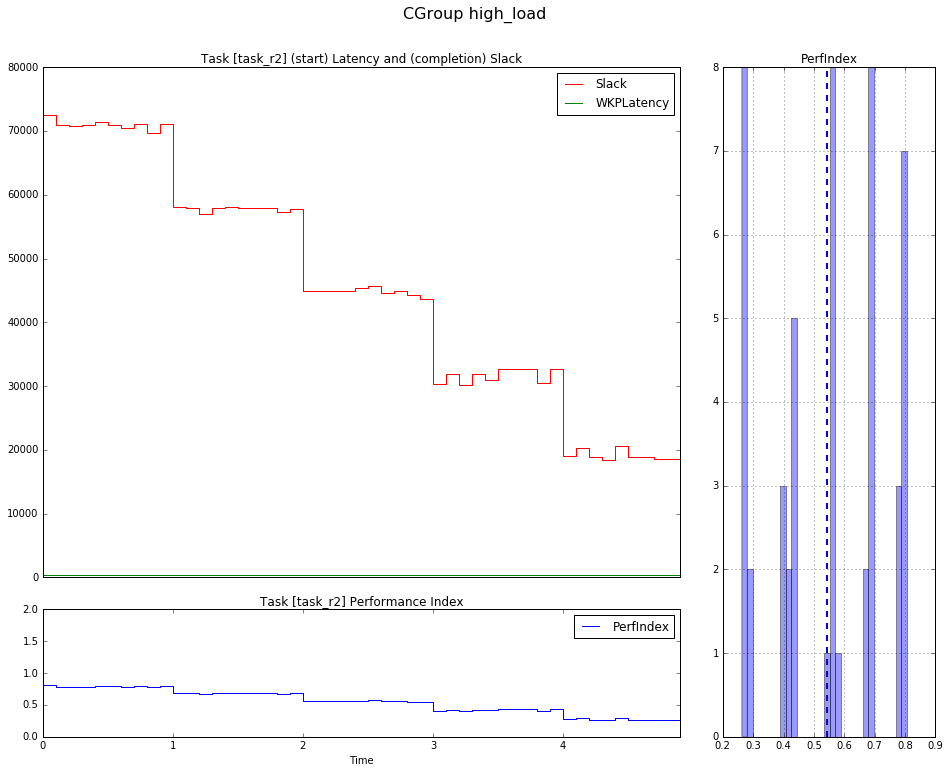

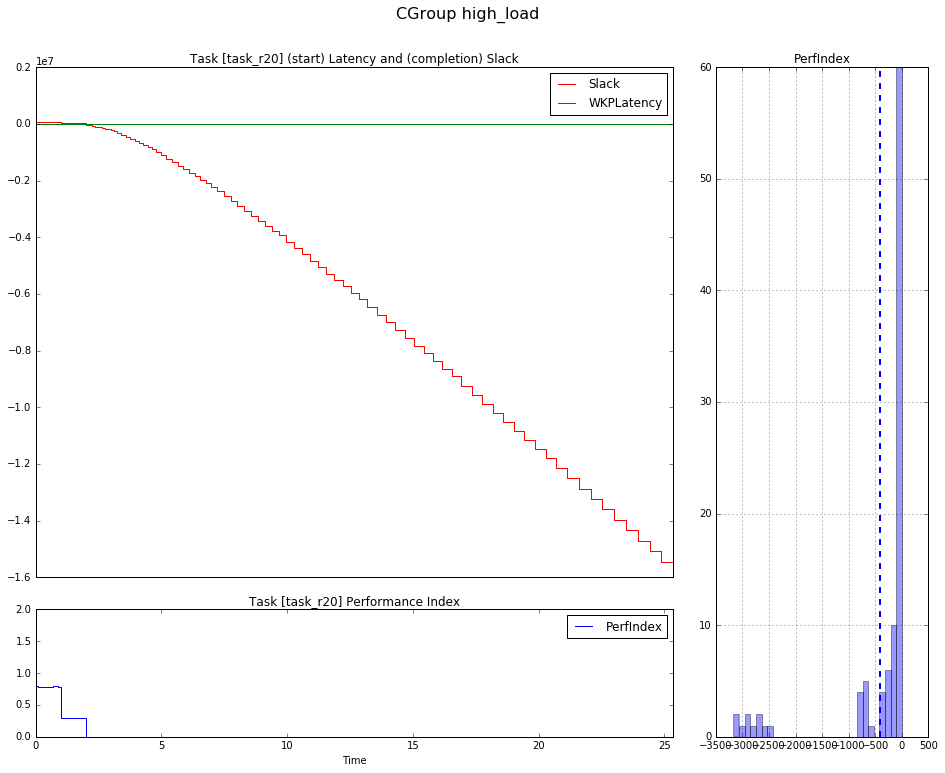

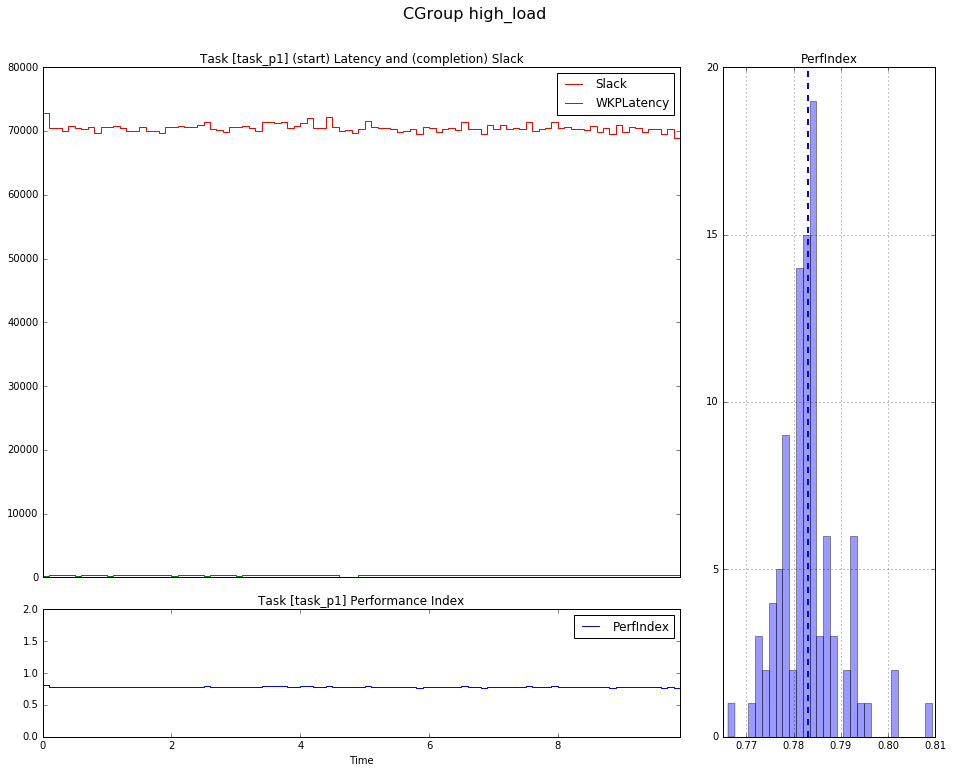

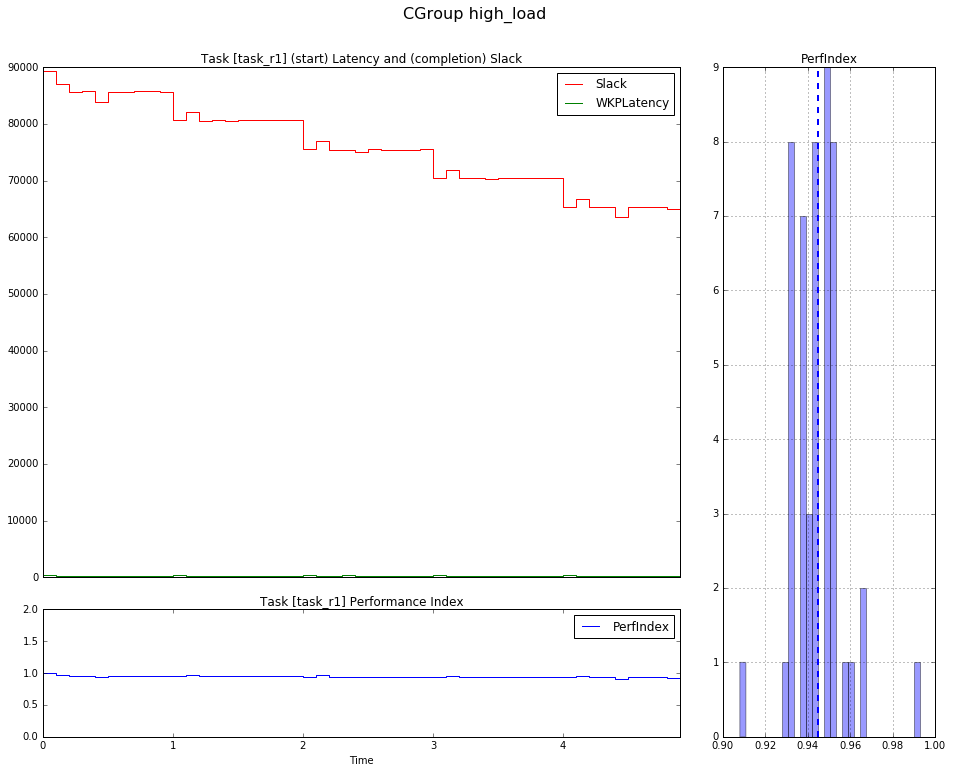

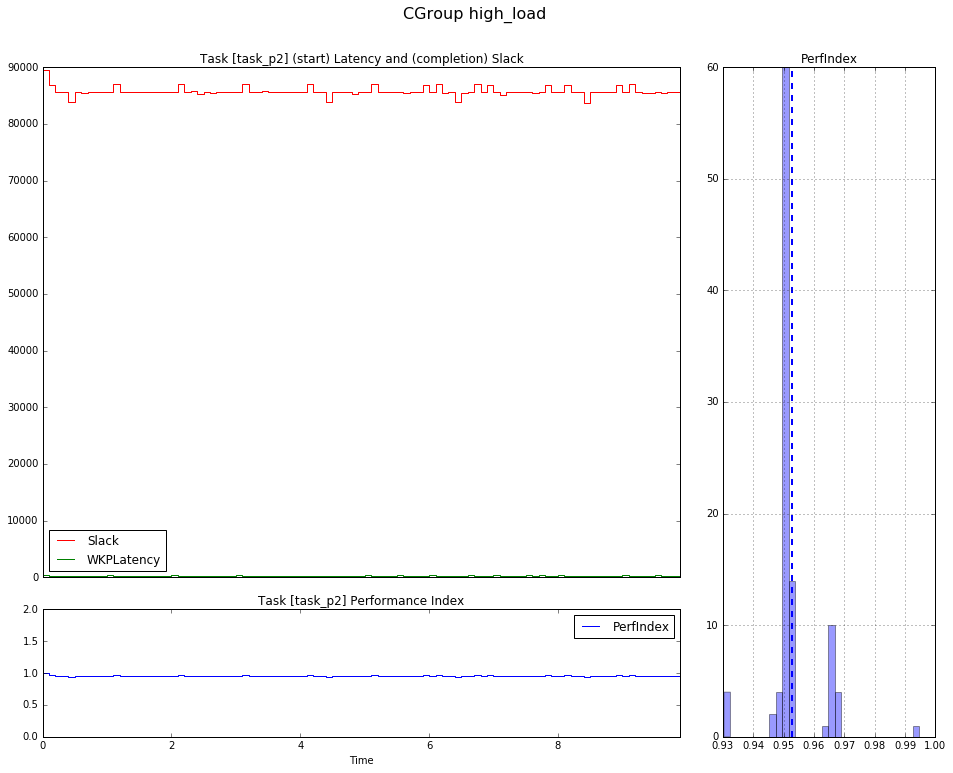

In [16]:
pa = PerfAnalysis( te.res_dir )

for task in pa.tasks():
    pa.plotPerf(task, "CGroup high_load")

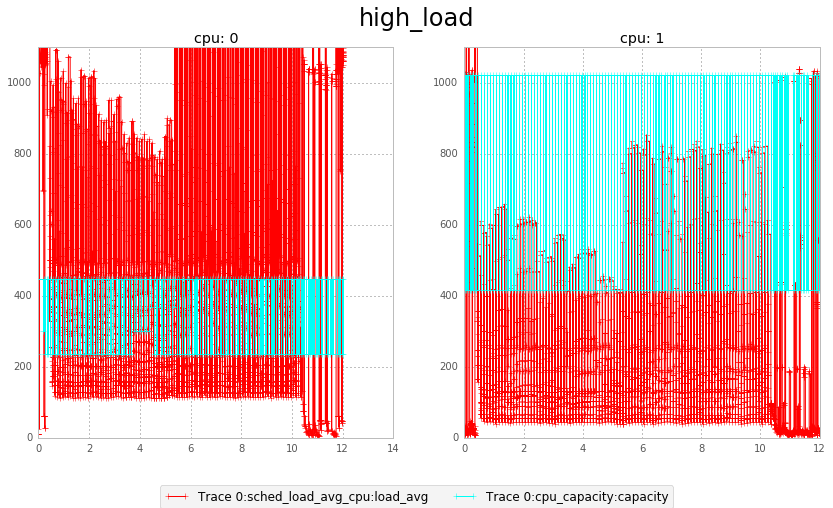

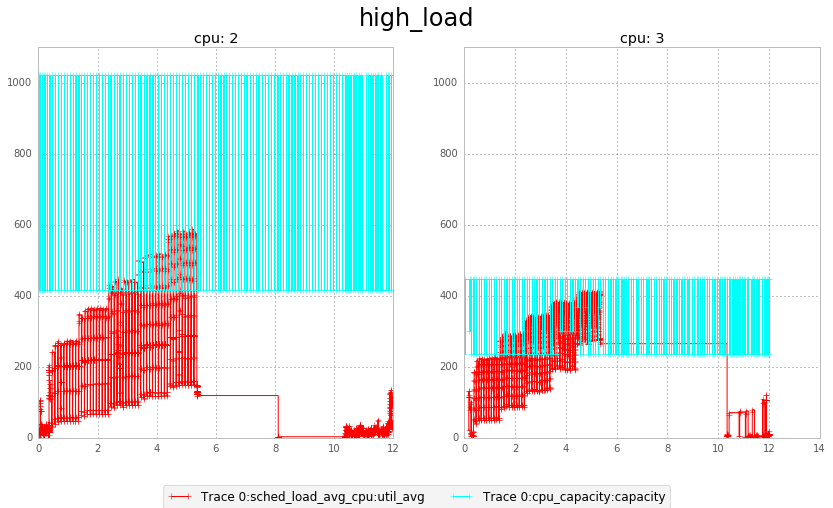

In [17]:
trappy.LinePlot(ftrace,
    signals=[
    #"sched_load_avg_cpu:util_avg",
    "sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [0,1]},
    marker = '+',
    drawstyle='steps-post',
    title="high_load",
    ylim=(0, 1100)).view()

trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [2,3]},
    marker = '+',
    drawstyle='steps-post',
    title="high_load",
    ylim=(0, 1100)).view()

# Workload Execution Round: low_load cgroup

In [18]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="low_load")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

05:17:42  INFO    : #### Setup FTrace
05:17:42  DEBUG   : adb -s 192.168.1.101:5555 shell "echo 'echo 10240 > '\\''/sys/kernel/debug/tracing/buffer_size_kb'\\''' | su"
05:17:43  DEBUG   : adb -s 192.168.1.101:5555 shell "cat '/sys/kernel/debug/tracing/buffer_size_kb'"
05:17:43  DEBUG   : adb -s 192.168.1.101:5555 shell "echo '/data/local/tmp/bin/trace-cmd reset' | su"
05:17:44  DEBUG   : adb -s 192.168.1.101:5555 shell "echo '/data/local/tmp/bin/trace-cmd start -e cpu_frequency -e sched_load_avg_cpu -e sched_load_avg_task -e sched_switch -e cpu_capacity -e sched_blocked_reason -e sched_boost_cpu -e sched_boost_task -e sched_contrib_scale_f -e sched_cpu_hotplug -e sched_energy_diff -e sched_kthread_stop -e sched_kthread_stop_ret -e sched_load_avg_cpu -e sched_load_avg_task -e sched_migrate_task -e sched_move_numa -e sched_pi_setprio -e sched_process_exec -e sched_process_exit -e sched_process_fork -e sched_process_free -e sched_process_wait -e sched_stat_blocked -e sched_stat_iowait -e 

In [19]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_file)
print json.dumps(nrg, indent=4, sort_keys=True)

05:18:00  INFO    : Energy: /data/lisa_fork/lisa/results/eas_cgroup_cpuset/energy.json


{
    "LITTLE": 1.4672150000000101, 
    "big": 2.0086490000000197
}


# Trace Inspection

In [20]:
trappy.plotter.plot_trace(te.res_dir)

In [21]:
events_to_parse = my_tests_conf['ftrace']['events']

trace_low = Trace(plt, te.res_dir, events_to_parse)

ftrace_low = trace_low.ftrace

trappy.plotter.plot_trace(ftrace_low, execnames=['task_p1',  "task_p2",
                                             "task_r1",  "task_r2", 
                                            ])

05:18:11  DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/eas_cgroup_cpuset]...
05:18:11  DEBUG   : Parsing events: ['cpu_frequency', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_switch', 'dequeue_task_fair', 'enqueue_task_fair', 'set_next_entity', 'cpu_capacity', 'sched_blocked_reason', 'sched_boost_cpu', 'sched_boost_task', 'sched_contrib_scale_f', 'sched_cpu_hotplug', 'sched_energy_diff', 'sched_kthread_stop', 'sched_kthread_stop_ret', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_migrate_task', 'sched_move_numa', 'sched_pi_setprio', 'sched_process_exec', 'sched_process_exit', 'sched_process_fork', 'sched_process_free', 'sched_process_wait', 'sched_stat_blocked', 'sched_stat_iowait', 'sched_stat_runtime', 'sched_stat_sleep', 'sched_stat_wait', 'sched_stick_numa', 'sched_swap_numa', 'sched_switch', 'sched_tune_boostgroup_update', 'sched_tune_config', 'sched_tune_tasks_update', 'sched_tune_filter', 'sched_wait_task', 'sched_wake_idle_without_i

05:18:15  DEBUG   : Found rt-app logfile for task [task_r2]
05:18:15  DEBUG   : Found rt-app logfile for task [task_r20]
05:18:15  DEBUG   : Found rt-app logfile for task [task_p2]
05:18:15  DEBUG   : Found rt-app logfile for task [task_p1]
05:18:15  DEBUG   : Found rt-app logfile for task [task_r1]
05:18:15  DEBUG   : Loading dataframe for task [task_r2]...
05:18:15  DEBUG   : Loading dataframe for task [task_r20]...
05:18:15  DEBUG   : Loading dataframe for task [task_p1]...
05:18:15  DEBUG   : Loading dataframe for task [task_r1]...
05:18:15  DEBUG   : Loading dataframe for task [task_p2]...
05:18:15  INFO    : PerfIndex, Task [task_r2] avg: 0.54, std: 0.19
05:18:16  INFO    : PerfIndex, Task [task_r20] avg: -410.97, std: 841.39
05:18:17  INFO    : PerfIndex, Task [task_p1] avg: 0.79, std: 0.02
05:18:17  INFO    : PerfIndex, Task [task_r1] avg: 0.94, std: 0.01
05:18:18  INFO    : PerfIndex, Task [task_p2] avg: 0.95, std: 0.01


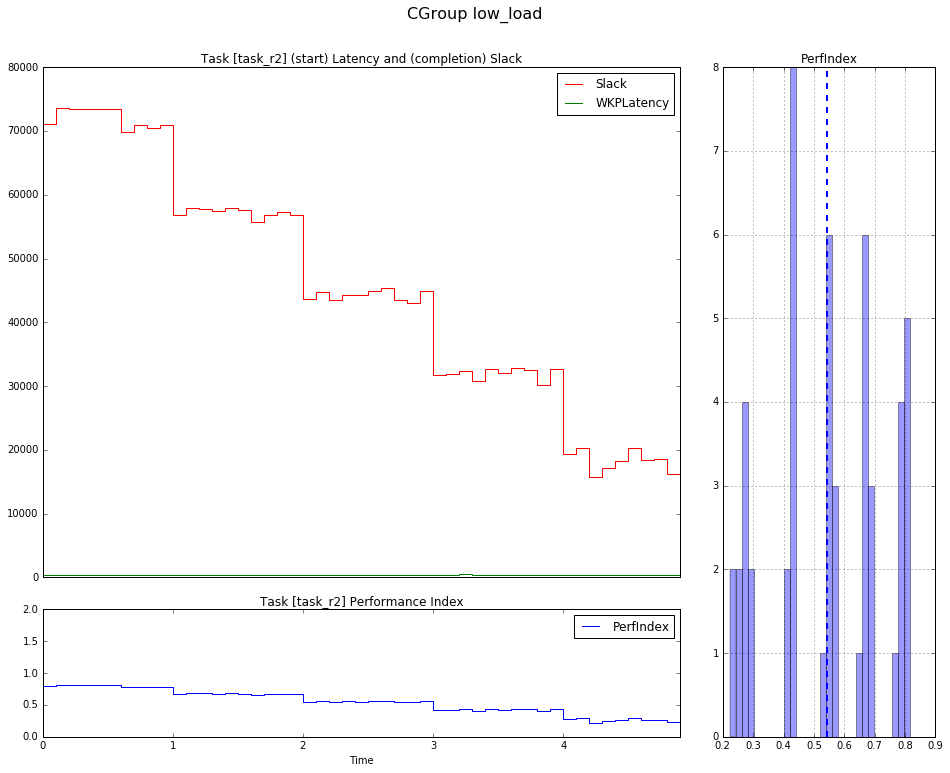

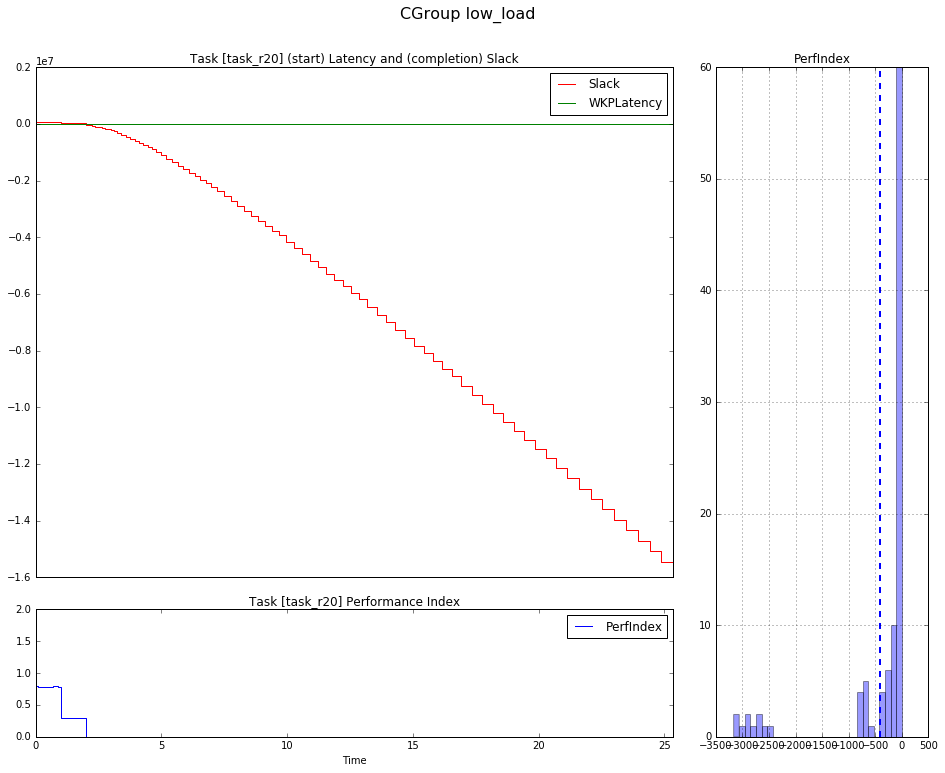

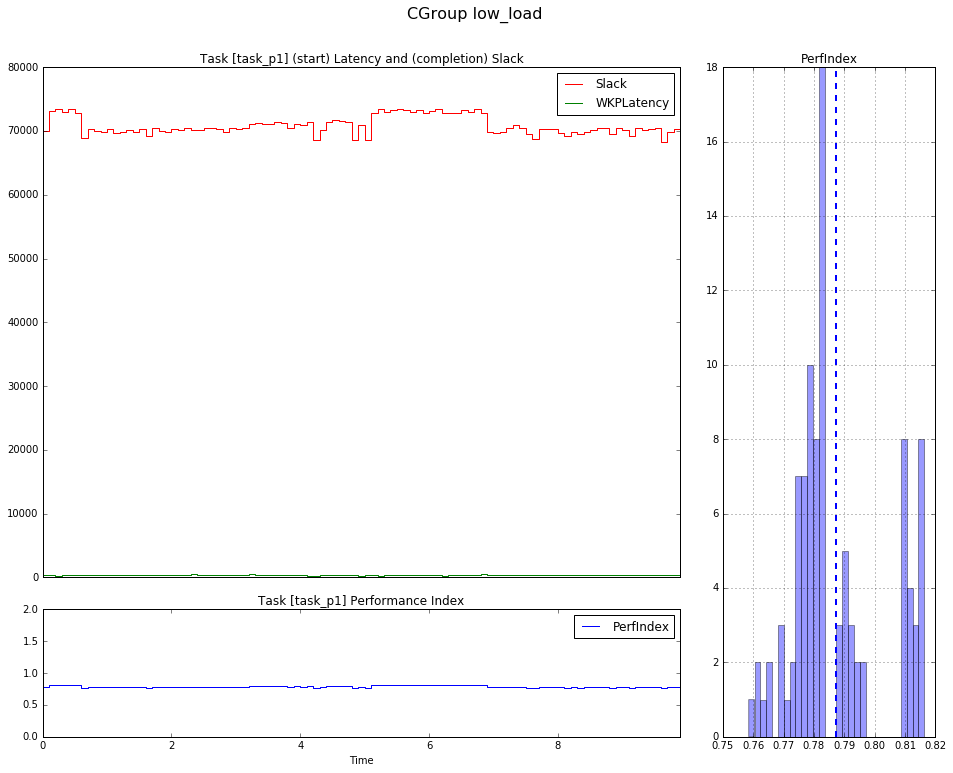

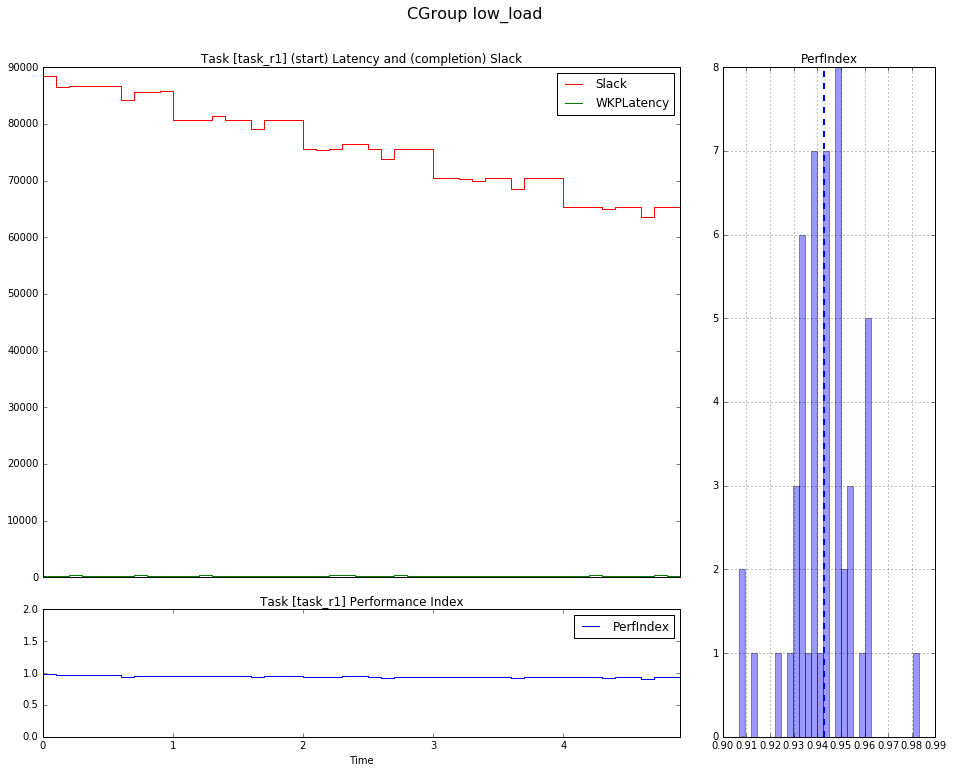

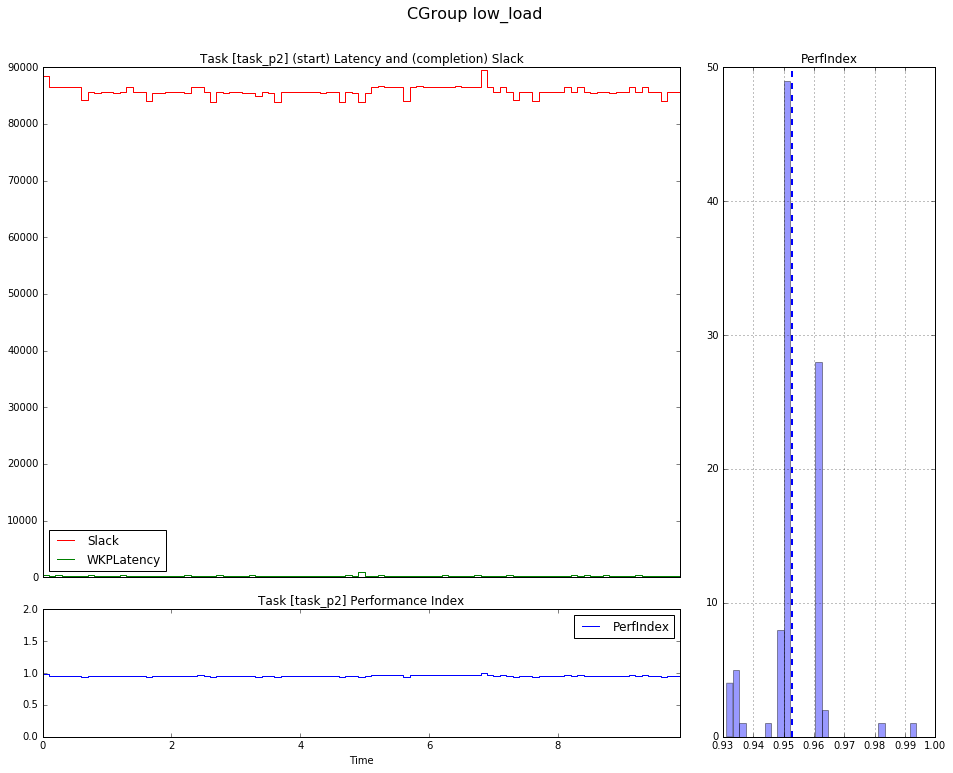

In [22]:
pa_low = PerfAnalysis( te.res_dir )

for task in pa_low.tasks():
    pa_low.plotPerf(task, "CGroup low_load")

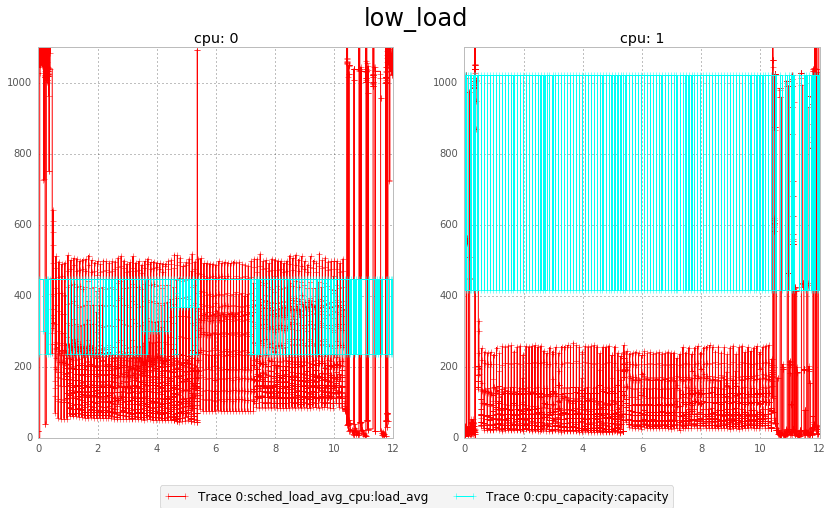

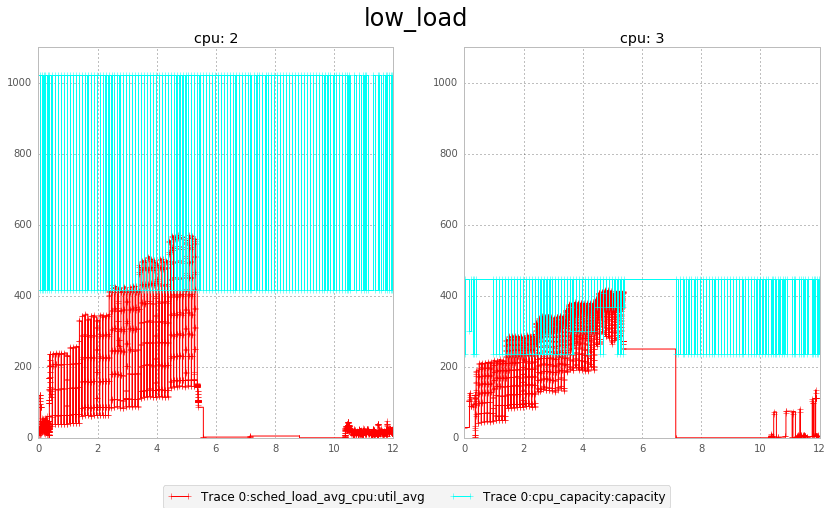

In [23]:
trappy.LinePlot(ftrace_low,
    signals=[
   # "sched_load_avg_cpu:util_avg",
    "sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [0,1]},
    marker = '+',
    drawstyle='steps-post',
    title="low_load",
    ylim=(0, 1100)).view()

trappy.LinePlot(ftrace_low,
    signals=[
    "sched_load_avg_cpu:util_avg",
   # "sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [2,3]},
    marker = '+',
    drawstyle='steps-post',
    title="low_load",
    ylim=(0, 1100)).view()